In [ ]:
pip install pandas matplotlib numpy scikit-learn tensorflow keras backtrader statsmodels xgboost

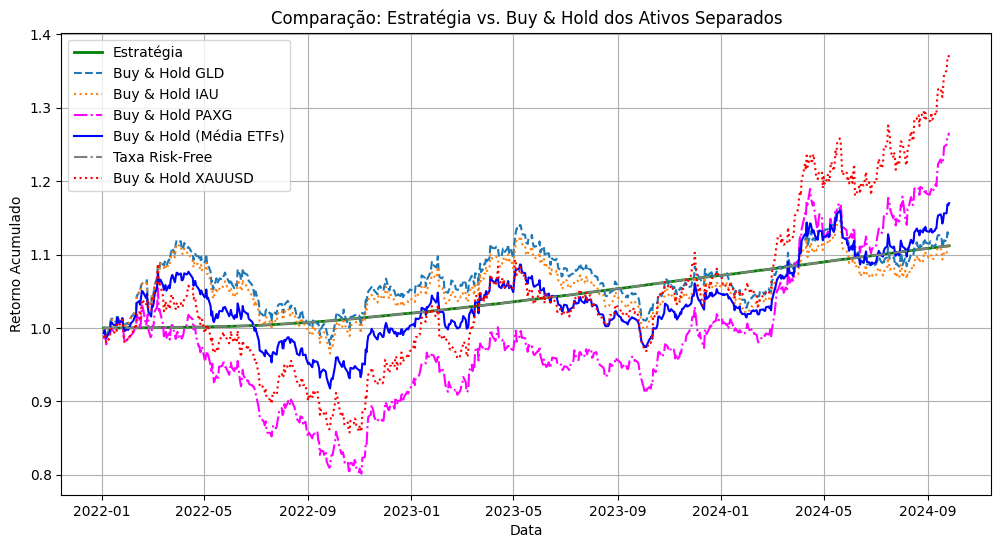

Retorno acumulado - Estratégia: 11.21%
Retorno acumulado - Buy & Hold GLD: 13.09%
Retorno acumulado - Buy & Hold IAU: 11.38%
Retorno acumulado - Buy & Hold PAXG: 26.60%
Retorno acumulado - Buy & Hold XAUUSD: 37.37%
Retorno acumulado - Taxa Risk-Free: 11.21%


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Carregamento dos dados
# -----------------------------
base_folder = r"C:\Users\samue\Documents\projeto Quant-H2\compiled_data"

# Carrega os dados diários dos ETFs, do XAUUSD e da taxa de juros (FRED)
gld   = pd.read_csv(os.path.join(base_folder, "GLD_daily.csv"), index_col=0, parse_dates=True)
iau   = pd.read_csv(os.path.join(base_folder, "IAU_daily.csv"), index_col=0, parse_dates=True)
paxg  = pd.read_csv(os.path.join(base_folder, "PAXG_daily.csv"), index_col=0, parse_dates=True)
xauusd = pd.read_csv(os.path.join(base_folder, "XAUUSD_daily.csv"), index_col=0, parse_dates=True)
fred  = pd.read_csv(os.path.join(base_folder, "fred_interest_rates.csv"), index_col=0, parse_dates=True)

# -----------------------------
# 2. Filtragem do período (2022 a 2025)
# -----------------------------
start = pd.to_datetime("2022-01-01")
end   = pd.to_datetime("2025-01-01")

gld   = gld[(gld.index >= start) & (gld.index < end)]
iau   = iau[(iau.index >= start) & (iau.index < end)]
paxg  = paxg[(paxg.index >= start) & (paxg.index < end)]
xauusd = xauusd[(xauusd.index >= start) & (xauusd.index < end)]
fred  = fred[(fred.index >= start) & (fred.index < end)]

# -----------------------------
# 3. Ajuste de escalas (preço por onça)
# -----------------------------
# GLD: cada cota representa 1/10 de onça => multiplicar por 10
gld["price_oz"] = gld["close"] * 10
# IAU: cada cota representa 1/100 de onça => multiplicar por 100
iau["price_oz"] = iau["close"] * 100
# PAXG: já representa 1 onça
paxg["price_oz"] = paxg["close"]
# XAUUSD: já está em preço por onça (usamos a coluna "close")

# -----------------------------
# 4. Alinhamento dos dados
# -----------------------------
# Para os ETFs e XAUUSD, usamos a interseção dos índices
common_dates = gld.index.intersection(iau.index).intersection(paxg.index).intersection(xauusd.index)
gld    = gld.loc[common_dates]
iau    = iau.loc[common_dates]
paxg   = paxg.loc[common_dates]
xauusd = xauusd.loc[common_dates]

# Para o FRED, criamos um DateRange de dias úteis e reindexamos com ffill
business_dates = pd.date_range(start, end, freq='B')
fred = fred.sort_index().reindex(business_dates, method='ffill')

# Usamos a coluna 'close' para representar a taxa de juros (pois open, high, low, close são iguais)
if "close" not in fred.columns:
    raise Exception("O arquivo FRED não possui a coluna 'close'.")
fred["risk_free"] = (1 + fred["close"] / 100) ** (1/252) - 1

# -----------------------------
# 5. Criação do DataFrame unificado com preços ajustados
# -----------------------------
df = pd.DataFrame(index=common_dates)
df["GLD"]    = gld["price_oz"]
df["IAU"]    = iau["price_oz"]
df["PAXG"]   = paxg["price_oz"]
df["XAUUSD"] = xauusd["close"]

# Preço médio dos ETFs (direito ao ouro)
df["avg_etf"] = df[["GLD", "IAU", "PAXG"]].mean(axis=1)

# Junta a taxa risk_free no DataFrame unificado (reindexando para as datas comuns)
fred_risk = fred["risk_free"].reindex(df.index, method='ffill')
df = df.join(fred_risk)

# -----------------------------
# 6. Geração do sinal de arbitragem
# -----------------------------
# Estratégia: Se o preço médio dos ETFs estiver abaixo do preço do XAUUSD, 
# sinal = 1 (comprar ETFs, vender XAUUSD); caso contrário, sinal = 0.
df["signal"] = np.where(df["avg_etf"] < df["XAUUSD"], 1, 0)

# -----------------------------
# 7. Cálculo dos retornos diários dos ativos
# -----------------------------
# Retornos diários (open-to-close) para os ETFs
gld["ret"]    = (gld["close"] * 10 / (gld["open"] * 10)) - 1
iau["ret"]    = (iau["close"] * 100 / (iau["open"] * 100)) - 1
paxg["ret"]   = (paxg["close"] / paxg["open"]) - 1
# Retorno do XAUUSD (open-to-close)
xauusd["ret"] = (xauusd["close"] / xauusd["open"]) - 1

# Retorno individual dos ETFs
cum_gld  = (1 + gld["ret"]).cumprod()
cum_iau  = (1 + iau["ret"]).cumprod()
cum_paxg = (1 + paxg["ret"]).cumprod()

# Retorno médio dos ETFs (buy & hold dos direitos ao ouro)
df["etf_ret"] = (gld["ret"] + iau["ret"] + paxg["ret"]) / 3.0
# Retorno do XAUUSD (buy & hold do ouro físico)
df["xauusd_ret"] = xauusd["ret"]

# -----------------------------
# 8. Cálculo do retorno da estratégia
# -----------------------------
# Se o sinal do dia anterior for 0 (sem posição), aloca o capital na taxa risk_free.
# Se o sinal for 1, assume a posição (comprar ETFs, vender XAUUSD): retorno = etf_ret - xauusd_ret.
df["strategy_ret"] = np.where(
    df["signal"].shift(1) == 0,
    df["risk_free"],
    df["signal"].shift(1) * (df["etf_ret"] - df["xauusd_ret"])
)
df["cum_ret"] = (1 + df["strategy_ret"].fillna(0)).cumprod()

# -----------------------------
# 9. Cálculo do retorno buy & hold da taxa risk_free
# -----------------------------
cum_riskfree = (1 + fred_risk.reindex(df.index, method='ffill')).cumprod()

# -----------------------------
# 10. Visualização dos resultados
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(df.index, df["cum_ret"], label="Estratégia", color="green", linewidth=2)
plt.plot(df.index, cum_gld, label="Buy & Hold GLD", linestyle="--")
plt.plot(df.index, cum_iau, label="Buy & Hold IAU", linestyle=":")
plt.plot(df.index, cum_paxg, label="Buy & Hold PAXG", linestyle="-.", color="magenta")
plt.plot(df.index, (cum_gld+cum_iau+cum_paxg)/3.0, label="Buy & Hold (Média ETFs)", linestyle="-", color="blue")
plt.plot(df.index, (1+fred_risk.reindex(df.index, method='ffill')).cumprod(), label="Taxa Risk-Free", linestyle="-.", color="gray")
plt.plot(df.index, (1 + xauusd["ret"]).cumprod(), label="Buy & Hold XAUUSD", linestyle=":", color="red")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.title("Comparação: Estratégia vs. Buy & Hold dos Ativos Separados")
plt.legend()
plt.grid(True)
plt.show()

# Exibe os retornos finais
print("Retorno acumulado - Estratégia: {:.2f}%".format((df['cum_ret'].iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold GLD: {:.2f}%".format((cum_gld.iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold IAU: {:.2f}%".format((cum_iau.iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold PAXG: {:.2f}%".format((cum_paxg.iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold XAUUSD: {:.2f}%".format(((1 + xauusd["ret"]).cumprod().iloc[-1]-1)*100))
print("Retorno acumulado - Taxa Risk-Free: {:.2f}%".format((cum_riskfree.iloc[-1]-1)*100))


Epoch 1/100


C:\Users\samue\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0232 - val_loss: 0.0695
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - val_loss: 0.0225
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0104
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - val_loss: 0.0067
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 0.0066
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0058
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

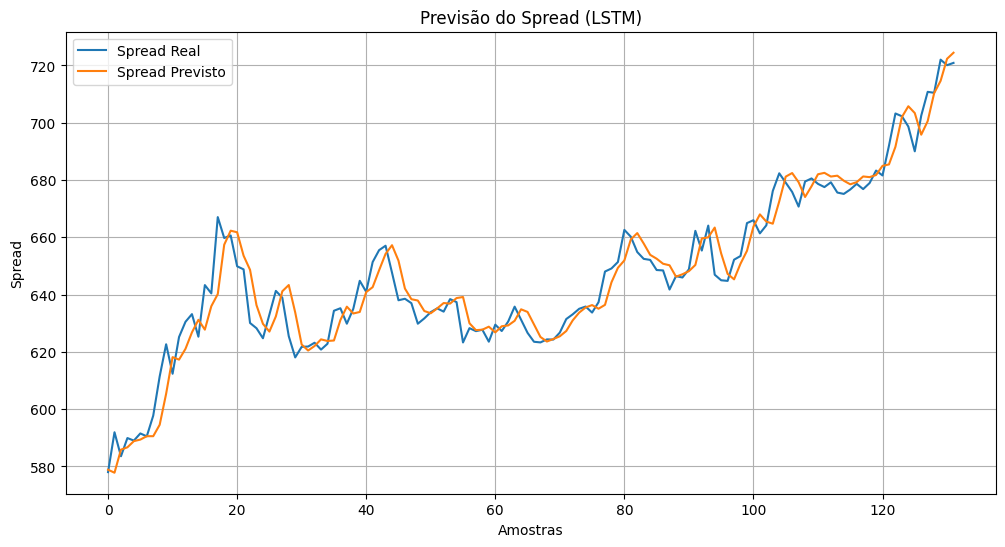

Sinal de Trading gerado: 0


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# ----- Etapas de carregamento e preparação dos dados -----

# Caminho para a pasta compilada
base_folder = r"C:\Users\samue\Documents\projeto Quant-H2\compiled_data"

# Carrega os dados diários dos ETFs e do XAUUSD
gld   = pd.read_csv(os.path.join(base_folder, "GLD_daily.csv"), index_col=0, parse_dates=True)
iau   = pd.read_csv(os.path.join(base_folder, "IAU_daily.csv"), index_col=0, parse_dates=True)
paxg  = pd.read_csv(os.path.join(base_folder, "PAXG_daily.csv"), index_col=0, parse_dates=True)
xauusd = pd.read_csv(os.path.join(base_folder, "XAUUSD_daily.csv"), index_col=0, parse_dates=True)

# Filtra para o período de interesse (por exemplo, 2022 a 2025)
start = pd.to_datetime("2022-01-01")
end   = pd.to_datetime("2025-01-01")
gld   = gld[(gld.index >= start) & (gld.index < end)]
iau   = iau[(iau.index >= start) & (iau.index < end)]
paxg  = paxg[(paxg.index >= start) & (paxg.index < end)]
xauusd = xauusd[(xauusd.index >= start) & (xauusd.index < end)]

# ----- Ajuste de escalas para representar o preço por onça -----
# GLD: 1 cota representa 1/10 de onça => multiplicar por 10
gld["price_oz"] = gld["close"] * 10
# IAU: 1 cota representa 1/100 de onça => multiplicar por 100
iau["price_oz"] = iau["close"] * 100
# PAXG: já representa 1 onça
paxg["price_oz"] = paxg["close"]
# XAUUSD: já está em preço por onça (usamos a coluna "close")

# ----- Alinhamento dos dados -----
common_dates = gld.index.intersection(iau.index).intersection(paxg.index).intersection(xauusd.index)
gld    = gld.loc[common_dates]
iau    = iau.loc[common_dates]
paxg   = paxg.loc[common_dates]
xauusd = xauusd.loc[common_dates]

# Cria um DataFrame unificado com os preços ajustados
df = pd.DataFrame(index=common_dates)
df["GLD"]    = gld["price_oz"]
df["IAU"]    = iau["price_oz"]
df["PAXG"]   = paxg["price_oz"]
df["XAUUSD"] = xauusd["close"]

# Calcula o preço médio dos ETFs (que representam os direitos ao ouro)
df["avg_etf"] = df[["GLD", "IAU", "PAXG"]].mean(axis=1)

# Calcula o spread: diferença entre o preço médio dos ETFs e o preço do ouro físico
df["spread"] = df["avg_etf"] - df["XAUUSD"]

# ----- Preparo dos dados para o modelo LSTM -----
# Utilizaremos apenas a coluna 'spread' para previsão
df.dropna(inplace=True)

# Usando um look-back de 30 dias para prever o spread do próximo dia
n_steps = 30

# Extraindo o array de spread e redimensionando
spread_data = df["spread"].values.reshape(-1, 1)

# Escalonando os dados para o intervalo [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
spread_scaled = scaler.fit_transform(spread_data)

# Função para criar sequências de tempo (X) e target (y)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(spread_scaled, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Divisão em conjuntos de treinamento e teste (80% treino, 20% teste)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ----- Construção do Modelo LSTM -----
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento com EarlyStopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)

# ----- Previsão do Spread -----
y_pred = model.predict(X_test)
# Inverter a escala para obter os valores reais
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualização das previsões
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Spread Real')
plt.plot(y_pred_inv, label='Spread Previsto')
plt.title("Previsão do Spread (LSTM)")
plt.xlabel("Amostras")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()

# ----- Geração de Sinais de Trading com Base na Previsão -----
# Exemplo simples:
# Se o spread previsto for negativo, isso indica que os direitos (ETFs) estão mais baratos que o ouro físico,
# gerando sinal = 1 (comprar ETFs e vender ouro); caso contrário, sinal = 0.
# Aqui usamos a previsão do último ponto do conjunto de teste para exemplificar.
last_pred = y_pred_inv[-1, 0]
signal = 1 if last_pred < 0 else 0
print("Sinal de Trading gerado:", signal)

# Você pode integrar essa previsão diária em uma lógica de trading para cada dia.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Carregamento dos dados
# -----------------------------
folder = r"C:\Users\samue\Documents\projeto Quant-H2\compiled_data"

# Carrega os dados diários dos ativos
paxg = pd.read_csv(os.path.join(folder, "PAXG_daily.csv"), index_col=0, parse_dates=True)
xauusd = pd.read_csv(os.path.join(folder, "XAUUSD_daily.csv"), index_col=0, parse_dates=True)
fred = pd.read_csv(os.path.join(folder, "fred_interest_rates.csv"), index_col=0, parse_dates=True)

# -----------------------------
# 2. Filtragem do período (ex.: 2022 a 2025)
# -----------------------------
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2025-01-01")

paxg = paxg[(paxg.index >= start) & (paxg.index < end)]
xauusd = xauusd[(xauusd.index >= start) & (xauusd.index < end)]
fred = fred[(fred.index >= start) & (fred.index < end)]

# -----------------------------
# 3. Alinhamento dos dados
# -----------------------------
# Para PAXG e XAUUSD usamos a interseção dos índices
common_dates = paxg.index.intersection(xauusd.index)
paxg = paxg.loc[common_dates]
xauusd = xauusd.loc[common_dates]

# Para o FRED, reindexamos para os dias úteis
business_dates = pd.date_range(start, end, freq='B')
fred = fred.sort_index().reindex(business_dates, method='ffill')
# Usamos a coluna 'close' para representar a taxa (pois open, high, low, close são iguais)
if "close" not in fred.columns:
    raise Exception("O arquivo FRED não possui a coluna 'close'.")
fred["risk_free"] = (1 + fred["close"] / 100) ** (1/252) - 1
fred_risk = fred["risk_free"].reindex(common_dates, method='ffill')

# -----------------------------
# 4. Criação do DataFrame unificado
# -----------------------------
df = pd.DataFrame(index=common_dates)
# PAXG já representa 1 onça; usamos seu preço de fechamento
df["PAXG"] = paxg["close"]
# XAUUSD: usamos o preço de fechamento (já em onça)
df["XAUUSD"] = xauusd["close"]

# -----------------------------
# 5. Geração do sinal de arbitragem
# -----------------------------
# Se PAXG estiver abaixo do XAUUSD, então os direitos ao ouro estão "baratos"
df["signal"] = np.where(df["PAXG"] < df["XAUUSD"], 1, 0)

# -----------------------------
# 6. Cálculo dos retornos diários dos ativos
# -----------------------------
# Cálculo do retorno diário (open-to-close)
paxg["ret"] = (paxg["close"] / paxg["open"]) - 1
xauusd["ret"] = (xauusd["close"] / xauusd["open"]) - 1

df["paxg_ret"] = paxg["ret"]
df["xauusd_ret"] = xauusd["ret"]

# -----------------------------
# 7. Cálculo do retorno da estratégia
# -----------------------------
# Se estiver posicionado (sinal do dia anterior = 1): 
# retorno = (paxg_ret - xauusd_ret)
# Caso contrário, capital rende a taxa risk-free.
df["strategy_ret"] = np.where(
    df["signal"].shift(1) == 1,
    df["paxg_ret"] - df["xauusd_ret"],
    fred_risk
)
df["cum_strategy"] = (1 + df["strategy_ret"].fillna(0)).cumprod()

# -----------------------------
# 8. Cálculo dos retornos buy & hold para comparação
# -----------------------------
cum_paxg = (1 + paxg["ret"]).cumprod()
cum_xauusd = (1 + xauusd["ret"]).cumprod()
cum_riskfree = (1 + fred_risk).cumprod()

# -----------------------------
# 9. Visualização dos resultados
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(df.index, df["cum_strategy"], label="Estratégia (PAXG vs. XAUUSD)", color="purple", linewidth=2)
plt.plot(df.index, cum_paxg, label="Buy & Hold PAXG", linestyle="--")
plt.plot(df.index, cum_xauusd, label="Buy & Hold XAUUSD", linestyle=":")
plt.plot(df.index, cum_riskfree, label="Taxa Risk-Free", linestyle="-.", color="gray")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.title("Arbitragem: Comprar PAXGOLD vs. Vender Ouro Físico (XAUUSD)")
plt.legend()
plt.grid(True)
plt.show()

# Exibe os retornos finais
print("Retorno acumulado da estratégia: {:.2f}%".format((df["cum_strategy"].iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold PAXG: {:.2f}%".format((cum_paxg.iloc[-1]-1)*100))
print("Retorno acumulado - Buy & Hold XAUUSD: {:.2f}%".format((cum_xauusd.iloc[-1]-1)*100))
print("Retorno acumulado - Taxa Risk-Free: {:.2f}%".format((cum_riskfree.iloc[-1]-1)*100))


Epoch 1/50


C:\Users\samue\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1824 - val_loss: 0.1096
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0600 - val_loss: 0.0897
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0531 - val_loss: 0.0930
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0445 - val_loss: 0.0862
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0394 - val_loss: 0.0900
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0372 - val_loss: 0.0759
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0336 - val_loss: 0.0725
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0333 - val_loss: 0.0528
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0332 - val_loss: 0.0487
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0323 - val_loss: 0.0514
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0275 - val_loss: 0.0493
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0320 - val_l

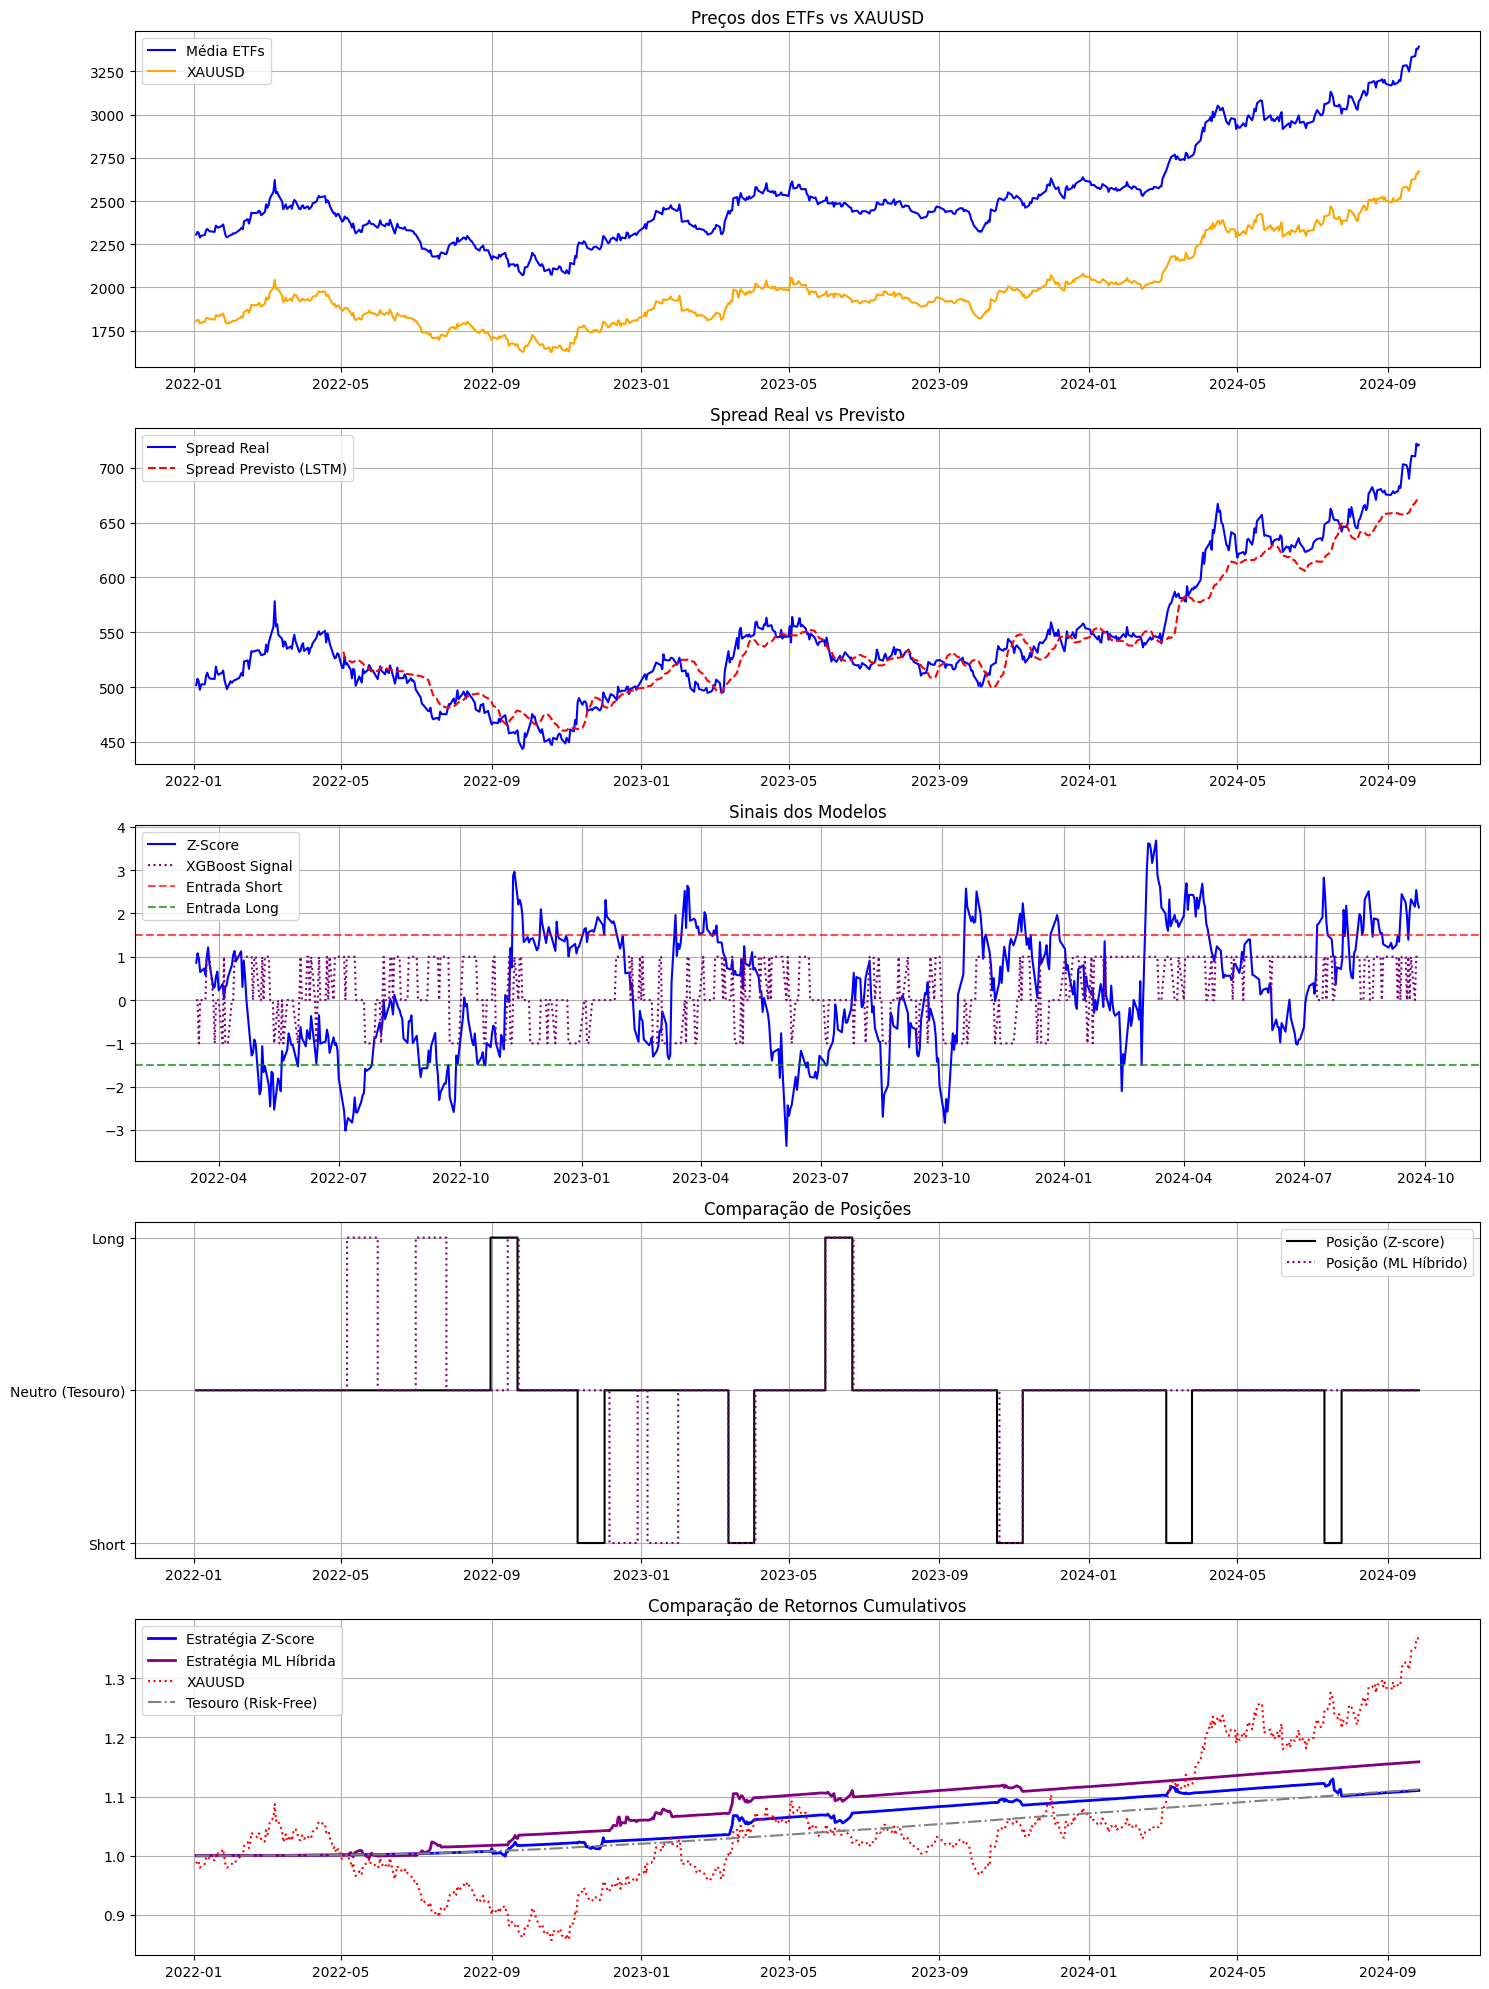


===== RESULTADOS COMPARATIVOS =====

[Estratégia Z-Score Tradicional]
Retorno acumulado: 11.03%
Retorno anualizado: 3.91%
Volatilidade anualizada: 2.74%
Índice de Sharpe: 0.01
Drawdown máximo: -2.54%
Total de trades: 15
Trades por ano: 5.5
% tempo investido em tesouro: 85.4%

[Estratégia ML Híbrida]
Retorno acumulado: 15.88%
Retorno anualizado: 5.56%
Volatilidade anualizada: 2.86%
Índice de Sharpe: 0.58
Drawdown máximo: -1.40%
Total de trades: 17
Trades por ano: 6.2
% tempo investido em tesouro: 83.1%

[Comparativo de Mercado]
Buy & Hold PAXG: 26.60%
Buy & Hold XAUUSD: 37.37%
Buy & Hold Tesouro: 11.21%


In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix

###############################################
# 1. Carregamento e Preparação dos Dados
###############################################
base_folder = r"C:\Users\samue\Documents\projeto Quant-H2\compiled_data"

# Carrega os dados diários
gld    = pd.read_csv(os.path.join(base_folder, "GLD_daily.csv"), index_col=0, parse_dates=True)
iau    = pd.read_csv(os.path.join(base_folder, "IAU_daily.csv"), index_col=0, parse_dates=True)
paxg   = pd.read_csv(os.path.join(base_folder, "PAXG_daily.csv"), index_col=0, parse_dates=True)
xauusd = pd.read_csv(os.path.join(base_folder, "XAUUSD_daily.csv"), index_col=0, parse_dates=True)
fred   = pd.read_csv(os.path.join(base_folder, "fred_interest_rates.csv"), index_col=0, parse_dates=True)

# Define o período de análise
start = pd.to_datetime("2022-01-01")
end   = pd.to_datetime("2025-01-01")

gld    = gld[(gld.index >= start) & (gld.index < end)]
iau    = iau[(iau.index >= start) & (iau.index < end)]
paxg   = paxg[(paxg.index >= start) & (paxg.index < end)]
xauusd = xauusd[(xauusd.index >= start) & (xauusd.index < end)]
fred   = fred[(fred.index >= start) & (fred.index < end)]

###############################################
# 2. Ajuste de Escalas e Alinhamento dos Dados
###############################################
# Ajuste para preço por onça
gld["price_oz"] = gld["close"] * 10
iau["price_oz"] = iau["close"] * 100
paxg["price_oz"] = paxg["close"]

# Alinhamento dos dados
common_dates = gld.index.intersection(iau.index).intersection(paxg.index).intersection(xauusd.index)
gld    = gld.loc[common_dates]
iau    = iau.loc[common_dates]
paxg   = paxg.loc[common_dates]
xauusd = xauusd.loc[common_dates]

# Preparação da taxa livre de risco
business_dates = pd.date_range(start, end, freq='B')
fred = fred.sort_index().reindex(business_dates, method='ffill')
fred["risk_free"] = (1 + fred["close"] / 100) ** (1/252) - 1
fred_risk = fred["risk_free"].reindex(common_dates, method='ffill')

###############################################
# 3. Criação do DataFrame Unificado
###############################################
df = pd.DataFrame(index=common_dates)
df["GLD"]    = gld["price_oz"]
df["IAU"]    = iau["price_oz"]
df["PAXG"]   = paxg["price_oz"]
df["XAUUSD"] = xauusd["close"]
df["avg_etf"] = df[["GLD", "IAU", "PAXG"]].mean(axis=1)
df["spread"] = df["avg_etf"] - df["XAUUSD"]
df["risk_free"] = fred_risk

###############################################
# 4. Cálculo de Indicadores Técnicos
###############################################
# Z-score do spread com múltiplas janelas
window_short = 20
window_medium = 50
window_long = 100
window_z = window_medium  # Janela padrão para referências

# Z-scores para diferentes períodos
df["spread_ma_short"] = df["spread"].rolling(window=window_short).mean()
df["spread_std_short"] = df["spread"].rolling(window=window_short).std()
df["z_score_short"] = (df["spread"] - df["spread_ma_short"]) / df["spread_std_short"].replace(0, np.nan)

df["spread_ma"] = df["spread_ma_med"] = df["spread"].rolling(window=window_medium).mean()
df["spread_std"] = df["spread_std_med"] = df["spread"].rolling(window=window_medium).std()
df["z_score"] = df["z_score_med"] = (df["spread"] - df["spread_ma_med"]) / df["spread_std_med"].replace(0, np.nan)

df["spread_ma_long"] = df["spread"].rolling(window=window_long).mean()
df["spread_std_long"] = df["spread"].rolling(window=window_long).std() 
df["z_score_long"] = (df["spread"] - df["spread_ma_long"]) / df["spread_std_long"].replace(0, np.nan)

# Tendência do ouro e momentum do spread
df["xauusd_ma20"] = df["XAUUSD"].rolling(window=20).mean()
df["xauusd_ma50"] = df["XAUUSD"].rolling(window=50).mean()
df["xauusd_trend"] = np.where(df["xauusd_ma20"] > df["xauusd_ma50"], 1, -1)
df["spread_momentum"] = df["spread"].pct_change(5)
df["spread_vol"] = df["spread"].rolling(window=20).std() / abs(df["spread_ma"]).replace(0, np.nan)

###############################################
# 5. Preparação de Dados para Modelos Preditivos
###############################################
# Parâmetros para os modelos
lookback_days = 30
forecast_horizon = 5  # Prevemos o spread 5 dias à frente

# Função para criar sequências para LSTM
def create_sequences(data, seq_length, horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - horizon):
        X.append(data[i:(i + seq_length)])
        # Target: spread futuro
        y.append(data[i + seq_length + horizon - 1])
    return np.array(X), np.array(y)

# Preparar dados para LSTM (previsão de spread)
features = df[['spread', 'z_score', 'spread_momentum', 'xauusd_trend']].dropna()
feature_scaler = MinMaxScaler()
features_scaled = feature_scaler.fit_transform(features)

# Criar sequências para LSTM e dividir em treino/teste
X_seq, y_seq = create_sequences(features_scaled, lookback_days, forecast_horizon)
X_seq = X_seq.reshape(X_seq.shape[0], lookback_days, features.shape[1])
split_idx = int(0.7 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

###############################################
# 6. Modelo LSTM para Previsão do Spread
###############################################
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback_days, features.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.1),
    Dense(features.shape[1])  # Prever todas as features
])

lstm_model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Fazer previsões
all_seq, _ = create_sequences(features_scaled, lookback_days, forecast_horizon)
all_seq = all_seq.reshape(-1, lookback_days, features.shape[1])
predictions = lstm_model.predict(all_seq)

# Processar previsões
spread_predictions = feature_scaler.inverse_transform(predictions)[:, 0]
pred_indices = features.index[lookback_days + forecast_horizon - 1:lookback_days + forecast_horizon - 1 + len(spread_predictions)]
predicted_spreads = pd.Series(spread_predictions, index=pred_indices, name='predicted_spread')
df = df.join(predicted_spreads)

###############################################
# 7. Modelo XGBoost para Classificação
###############################################
# Preparação dos dados para XGBoost
features_for_xgb = features.copy()
features_for_xgb['future_return'] = df['spread'].shift(-forecast_horizon) - df['spread']
features_for_xgb['target'] = 0  # Inicializa como neutro

# Define targets para classificação
threshold_up = features_for_xgb['future_return'].quantile(0.7)
threshold_down = features_for_xgb['future_return'].quantile(0.3)
features_for_xgb.loc[features_for_xgb['future_return'] > threshold_up, 'target'] = -1  # Short
features_for_xgb.loc[features_for_xgb['future_return'] < threshold_down, 'target'] = 1  # Long

# Preparar X e y para treinamento
features_for_xgb = features_for_xgb.drop(['future_return'], axis=1).dropna()
X = features_for_xgb.drop(['target'], axis=1)
y = features_for_xgb['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Treinar modelo XGBoost
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train, y_train + 1)  # +1 para classes não-negativas

# Avaliar e fazer predições
test_preds = xgb_model.predict(X_test)
test_preds = test_preds - 1
print(f"Acurácia do XGBoost: {accuracy_score(y_test, test_preds):.4f}")
print("Matriz de confusão:")
print(confusion_matrix(y_test, test_preds))

# Predições para todo o dataset
all_preds = xgb_model.predict(X)
all_preds = all_preds - 1
df['xgb_signal'] = pd.Series(all_preds, index=X.index)

###############################################
# 8. Parâmetros da Estratégia
###############################################
# Parâmetros para entrada/saída
z_entry_threshold = 1.5
z_exit_threshold = 0.5
max_days_in_position = 15
transaction_cost = 0.0007  # 7 basis points

# Inicialização
df["position"] = 0  # Z-score tradicional
df["ml_position"] = 0  # Estratégia híbrida ML

###############################################
# 9. Estratégia Z-Score Tradicional
###############################################
position_days = 0

for i in range(window_long, len(df)):
    prev_pos = df["position"].iloc[i-1]
    z = df["z_score"].iloc[i]
    trend = df["xauusd_trend"].iloc[i]
    
    if prev_pos != 0:
        position_days += 1
    else:
        position_days = 0
    
    if position_days >= max_days_in_position:
        df.iloc[i, df.columns.get_loc("position")] = 0
        position_days = 0
        continue
    
    if prev_pos == 0:
        if z < -z_entry_threshold and trend == 1:
            df.iloc[i, df.columns.get_loc("position")] = 1  # Long ETF/Short XAUUSD
        elif z > z_entry_threshold and trend == -1:
            df.iloc[i, df.columns.get_loc("position")] = -1  # Short ETF/Long XAUUSD
        else:
            df.iloc[i, df.columns.get_loc("position")] = 0  # Neutro (Tesouro)
    
    elif prev_pos == 1:
        if z > -z_exit_threshold:
            df.iloc[i, df.columns.get_loc("position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("position")] = 1
    
    elif prev_pos == -1:
        if z < z_exit_threshold:
            df.iloc[i, df.columns.get_loc("position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("position")] = -1

###############################################
# 10. Estratégia Híbrida (Z-Score + ML)
###############################################
position_days = 0

for i in range(max(window_z, lookback_days + forecast_horizon), len(df)):
    prev_pos = df["ml_position"].iloc[i-1]
    z = df["z_score"].iloc[i]
    
    # Sinais dos modelos preditivos
    try:
        pred_spread = df["predicted_spread"].iloc[i]
        xgb_signal = df["xgb_signal"].iloc[i]
    except:
        pred_spread = np.nan
        xgb_signal = 0
        
    # Calculamos o z-score do spread previsto
    trend = df["xauusd_trend"].iloc[i]
    current_mean = df["spread_ma"].iloc[i]
    current_std = df["spread_std"].iloc[i]
    if not np.isnan(pred_spread) and current_std > 0:
        future_z = (pred_spread - current_mean) / current_std
    else:
        future_z = 0
    
    # Rastreamos dias na posição
    if prev_pos != 0:
        position_days += 1
    else:
        position_days = 0
        
    # Stop por tempo máximo na posição
    if position_days > max_days_in_position:
        df.iloc[i, df.columns.get_loc("ml_position")] = 0
        position_days = 0
        continue
    
    # Lógica híbrida de posicionamento
    if prev_pos == 0:  # Neutro (Tesouro)
        # Confirmação multi-modelo para entrada
        if z < -z_entry_threshold and xgb_signal == 1 and (trend == 1 or future_z < 0):
            # ETFs baratos + ML prevê subida
            df.iloc[i, df.columns.get_loc("ml_position")] = 1
        elif z > z_entry_threshold and xgb_signal == -1 and (trend == -1 or future_z > 0):
            # ETFs caros + ML prevê queda
            df.iloc[i, df.columns.get_loc("ml_position")] = -1
        else:
            df.iloc[i, df.columns.get_loc("ml_position")] = 0
    
    elif prev_pos == 1:  # Long
        if (z > -z_exit_threshold) or (xgb_signal == -1 and future_z > 0):
            df.iloc[i, df.columns.get_loc("ml_position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("ml_position")] = 1
    
    elif prev_pos == -1:  # Short
        if (z < z_exit_threshold) or (xgb_signal == 1 and future_z < 0):
            df.iloc[i, df.columns.get_loc("ml_position")] = 0
        else:
            df.iloc[i, df.columns.get_loc("ml_position")] = -1

###############################################
# 11. Cálculo dos Retornos
###############################################
# Retornos diários dos ativos
gld["ret"] = (gld["close"] / gld["open"]) - 1
iau["ret"] = (iau["close"] / iau["open"]) - 1
paxg["ret"] = (paxg["close"] / paxg["open"]) - 1
xauusd["ret"] = (xauusd["close"] / xauusd["open"]) - 1
df["etf_ret"] = (gld["ret"] + iau["ret"] + paxg["ret"]) / 3.0
df["xauusd_ret"] = xauusd["ret"]

# Retornos para estratégia Z-score tradicional
df["trade"] = df["position"] != df["position"].shift(1)
df["cost"] = np.where(df["trade"], transaction_cost, 0)

# Quando neutros, investimos no tesouro americano (risk_free)
df["strategy_ret"] = np.where(
    df["position"].shift(1) == 0,
    df["risk_free"] - df["cost"],
    df["position"].shift(1) * (df["etf_ret"] - df["xauusd_ret"]) - df["cost"]
)

df["cum_strategy"] = (1 + df["strategy_ret"].fillna(0)).cumprod()

# Retornos para estratégia ML híbrida
df["ml_trade"] = df["ml_position"] != df["ml_position"].shift(1)
df["ml_cost"] = np.where(df["ml_trade"], transaction_cost, 0)

# Quando neutros, investimos no tesouro americano (risk_free)
df["ml_strategy_ret"] = np.where(
    df["ml_position"].shift(1) == 0,
    df["risk_free"] - df["ml_cost"],
    df["ml_position"].shift(1) * (df["etf_ret"] - df["xauusd_ret"]) - df["ml_cost"]
)

df["cum_ml_strategy"] = (1 + df["ml_strategy_ret"].fillna(0)).cumprod()

# Retorno buy & hold
cum_gld = (1 + gld["ret"]).cumprod()
cum_iau = (1 + iau["ret"]).cumprod()
cum_paxg = (1 + paxg["ret"]).cumprod()
cum_xauusd = (1 + xauusd["ret"]).cumprod()
cum_riskfree = (1 + df["risk_free"]).cumprod()

###############################################
# 12. Métricas de Performance
###############################################
# Estatísticas para estratégia tradicional
years = len(df) / 252
annual_return = (df["cum_strategy"].iloc[-1] ** (1/years) - 1) * 100
daily_vol = df["strategy_ret"].std()
annual_vol = daily_vol * np.sqrt(252) * 100
avg_rf = df["risk_free"].mean() * 252 * 100
sharpe_ratio = (annual_return - avg_rf) / annual_vol if annual_vol > 0 else 0
df["peak"] = df["cum_strategy"].cummax()
df["drawdown"] = (df["cum_strategy"] / df["peak"] - 1) * 100
max_drawdown = df["drawdown"].min()
total_trades = df["trade"].sum()
trades_per_year = total_trades / years

# Estatísticas para estratégia ML
ml_annual_return = (df["cum_ml_strategy"].iloc[-1] ** (1/years) - 1) * 100
ml_daily_vol = df["ml_strategy_ret"].std()
ml_annual_vol = ml_daily_vol * np.sqrt(252) * 100
ml_sharpe_ratio = (ml_annual_return - avg_rf) / ml_annual_vol if ml_annual_vol > 0 else 0
df["ml_peak"] = df["cum_ml_strategy"].cummax()
df["ml_drawdown"] = (df["cum_ml_strategy"] / df["ml_peak"] - 1) * 100
ml_max_drawdown = df["ml_drawdown"].min()
ml_total_trades = df["ml_trade"].sum()
ml_trades_per_year = ml_total_trades / years

###############################################
# 13. Visualização Comparativa
###############################################
plt.figure(figsize=(15, 20))

# Subplot 1: Preços e Spread
plt.subplot(5, 1, 1)
plt.plot(df.index, df["avg_etf"], label="Média ETFs", color="blue")
plt.plot(df.index, df["XAUUSD"], label="XAUUSD", color="orange")
plt.title("Preços dos ETFs vs XAUUSD")
plt.legend()
plt.grid(True)

# Subplot 2: Spread Real vs Previsto
plt.subplot(5, 1, 2)
plt.plot(df.index, df["spread"], label="Spread Real", color="blue")
plt.plot(df.index, df["predicted_spread"], label="Spread Previsto (LSTM)", color="red", linestyle="--")
plt.title("Spread Real vs Previsto")
plt.legend()
plt.grid(True)

# Subplot 3: Sinais dos Modelos
plt.subplot(5, 1, 3)
plt.plot(df.index, df["z_score"], label="Z-Score", color="blue")
plt.plot(df.index, df["xgb_signal"], label="XGBoost Signal", color="purple", linestyle=":")
plt.axhline(y=z_entry_threshold, color='r', linestyle='--', alpha=0.7, label=f'Entrada Short')
plt.axhline(y=-z_entry_threshold, color='g', linestyle='--', alpha=0.7, label=f'Entrada Long')
plt.title("Sinais dos Modelos")
plt.legend()
plt.grid(True)

# Subplot 4: Posições (Tradicional vs ML)
plt.subplot(5, 1, 4)
plt.plot(df.index, df["position"], label="Posição (Z-score)", color="black", drawstyle="steps-post")
plt.plot(df.index, df["ml_position"], label="Posição (ML Híbrido)", color="purple", drawstyle="steps-post", linestyle=":")
plt.title("Comparação de Posições")
plt.yticks([-1, 0, 1], ["Short", "Neutro (Tesouro)", "Long"])
plt.legend()
plt.grid(True)

# Subplot 5: Retornos Cumulativos
plt.subplot(5, 1, 5)
plt.plot(df.index, df["cum_strategy"], label="Estratégia Z-Score", color="blue", linewidth=2)
plt.plot(df.index, df["cum_ml_strategy"], label="Estratégia ML Híbrida", color="purple", linewidth=2)
plt.plot(df.index, cum_xauusd, label="XAUUSD", linestyle=":", color="red")
plt.plot(df.index, cum_riskfree, label="Tesouro (Risk-Free)", linestyle="-.", color="gray")
plt.title("Comparação de Retornos Cumulativos")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

###############################################
# 14. Resultados Comparativos
###############################################
print("\n===== RESULTADOS COMPARATIVOS =====")
print("\n[Estratégia Z-Score Tradicional]")
print("Retorno acumulado: {:.2f}%".format((df["cum_strategy"].iloc[-1]-1)*100))
print("Retorno anualizado: {:.2f}%".format(annual_return))
print("Volatilidade anualizada: {:.2f}%".format(annual_vol))
print("Índice de Sharpe: {:.2f}".format(sharpe_ratio))
print("Drawdown máximo: {:.2f}%".format(max_drawdown))
print("Total de trades: {}".format(total_trades))
print("Trades por ano: {:.1f}".format(trades_per_year))
print("% tempo investido em tesouro: {:.1f}%".format(100 * (df["position"] == 0).sum() / len(df)))

print("\n[Estratégia ML Híbrida]")
print("Retorno acumulado: {:.2f}%".format((df["cum_ml_strategy"].iloc[-1]-1)*100))
print("Retorno anualizado: {:.2f}%".format(ml_annual_return))
print("Volatilidade anualizada: {:.2f}%".format(ml_annual_vol))
print("Índice de Sharpe: {:.2f}".format(ml_sharpe_ratio))
print("Drawdown máximo: {:.2f}%".format(ml_max_drawdown))
print("Total de trades: {}".format(ml_total_trades))
print("Trades por ano: {:.1f}".format(ml_trades_per_year))
print("% tempo investido em tesouro: {:.1f}%".format(100 * (df["ml_position"] == 0).sum() / len(df)))

print("\n[Comparativo de Mercado]")
print("Buy & Hold PAXG: {:.2f}%".format((cum_paxg.iloc[-1]-1)*100))
print("Buy & Hold XAUUSD: {:.2f}%".format((cum_xauusd.iloc[-1]-1)*100))
print("Buy & Hold Tesouro: {:.2f}%".format((cum_riskfree.iloc[-1]-1)*100))